# CASE STUDY 1: Feedforward Neural Networks for MNIST

In this case study, I build and compare different FFN architectures applied to a classification problem: the MNIST dataset. I build FFNs with 3 and 4 layers and different activation functions, different number of neurons per layer, and different optimizers.

## I- Preliminaries

First, I import the necessary libraries.

In [ ]:
#importing libraries
import tensorflow as tf
print(tf.__version__)

import os
import time

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

2.16.2


Then, I import the MNIST dataset and show an example from this dataset.

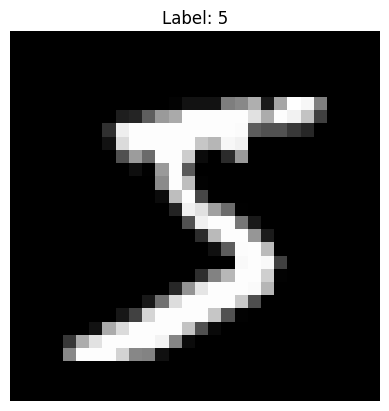

In [13]:
#importing the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#creating the input and output sizes
img_size = 28
n_classes = 10
input_size = img_size**2
output_size = n_classes


#showing the example of an image of the dataset
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')  # enlève les axes
plt.show()

I set-up the different variables used in the models.

In [14]:
x_train = np.reshape(x_train, [-1, img_size*img_size])
x_train = x_train.astype(np.float32)/255

x_test = np.reshape(x_test, [-1, img_size*img_size])
x_test = x_test.astype(np.float32)/255

to_categorical = tf.keras.utils.to_categorical 
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

ind = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[ind], y_train[ind]

# creating a 10% validation set from the training set
validatationPct = 0.1
n = int(x_train.shape[0] * (1-validatationPct))
x_valid = x_train[n:]
x_train = x_train[:n]
#
y_valid = y_train[n:]
y_train = y_train[:n]

print("x_train shape:", x_train.shape)
print("x_valid shape:", x_valid.shape)
print("x_test shape:", x_test.shape)

x_train shape: (54000, 784)
x_valid shape: (6000, 784)
x_test shape: (10000, 784)


Finally, I define the global paramaters used to train the models.

In [15]:
learning_rate = 0.05
training_epochs = 50
batch_size = 1000

display_step = 10

## II- Models Definition and Training Setup

Here, I define the loss function and the different models and optimizers that will be compared.

The loss used is the categorical cross-entropy. For a sample of N training entries, and C categories, its expression is:

$$
L = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \, \log(\hat{y}_{ij})
$$

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

I will use two different optimizers: RMSProp and Adam

In [17]:
optimizers = {
    "RMSprop": lambda: tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    "Adam":    lambda: tf.keras.optimizers.Adam(learning_rate=1e-3),
}

Now, I define the different 3 and 4 layers models compared.

In [18]:
#I define a function for leaky ReLU, which is used in some architectures that I will build
leaky_relu = lambda x: tf.nn.leaky_relu(x, alpha=0.01)

class Model1(tf.keras.Model):
        """1st layer: tanh, 2nd layer: sigmoid, 3rd layer: leaky ReLU"""
        def __init__(self, n_neurons):
            super(Model1, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation='tanh')
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            return self.output_layer(x)

class Model2(tf.keras.Model):
        """1st layer: tanh, 2nd layer: sigmoid, 3rd layer: sigmoid, 4th layer: ReLU"""
        def __init__(self, n_neurons):
            super(Model2, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation='tanh')
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.hidden_4 = tf.keras.layers.Dense(n_neurons, activation="relu")
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            x = self.hidden_4(x)
            return self.output_layer(x)

class Model3(tf.keras.Model):
        """3 layers all sigmoid"""
        def __init__(self, n_neurons):
            super(Model3, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation='sigmoid')
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            return self.output_layer(x)

class Model4(tf.keras.Model):
        """3 layers all leaky ReLU"""
        def __init__(self, n_neurons):
            super(Model4, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            return self.output_layer(x)

class Model5(tf.keras.Model):
        """4 layers all tanh"""
        def __init__(self, n_neurons):
            super(Model5, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation="tanh")
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation="tanh")
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation="tanh")
            self.hidden_4 = tf.keras.layers.Dense(n_neurons, activation="tanh")
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            x = self.hidden_4(x)
            return self.output_layer(x)

class Model6(tf.keras.Model):
        """4 layers all leaky ReLU"""
        def __init__(self, n_neurons):
            super(Model6, self).__init__()
            # Define layers
            self.hidden_1 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.hidden_2 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.hidden_3 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.hidden_4 = tf.keras.layers.Dense(n_neurons, activation=leaky_relu)
            self.output_layer = tf.keras.layers.Dense(output_size, activation="softmax")
        
        def call(self, inputs):
            # Forward pass
            x = self.hidden_1(inputs)
            x = self.hidden_2(x)
            x = self.hidden_3(x)
            x = self.hidden_4(x)
            return self.output_layer(x)

models = {"Model 1": Model1, "Model 2": Model2, "Model 3": Model3, "Model 4": Model4, "Model 5": Model5, "Model 6": Model6}

I will use 50 and 100 neurons per layer for each model.

In [19]:
nb_neurons = [50, 100]

## III- Models training and observation of the loss surface


### Models training

I will train each model with 50 and 100 neurons and two different optimizers.

In [20]:
histories = {}
trained_models = {}
theta_init = {}
theta_final = {}

for model_name, model in models.items():
    for n in nb_neurons:
        for opti_name, opti in optimizers.items():
            tested_model = model(n)

            tested_model.compile(optimizer=opti(), loss=loss, metrics=["accuracy"])
            histories[model_name, n, opti_name] = tested_model.fit(x_train, y_train, epochs=training_epochs, batch_size=batch_size, 
                                                                   validation_data=(x_valid, y_valid), verbose=1)

            trained_models[(model_name, n, opti_name)] = tested_model

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6726 - loss: 1.5347 - val_accuracy: 0.8180 - val_loss: 0.9281
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8573 - loss: 0.6504 - val_accuracy: 0.8767 - val_loss: 0.4751
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8972 - loss: 0.3888 - val_accuracy: 0.8973 - val_loss: 0.3519
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9152 - loss: 0.2991 - val_accuracy: 0.9128 - val_loss: 0.2909
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9273 - loss: 0.2526 - val_accuracy: 0.9235 - val_loss: 0.2561
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9363 - loss: 0.2210 - val_accuracy: 0.9297 - val_loss: 0.2348
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9431 - loss: 0.1968 - val_accuracy: 0.9343 - val_loss: 0.2144
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9481 - loss: 0.1768 - val_accuracy: 0.9402 - val_los

Now, I can plot the evolution of the loss and of the eval accuracy, epoch after epoch.

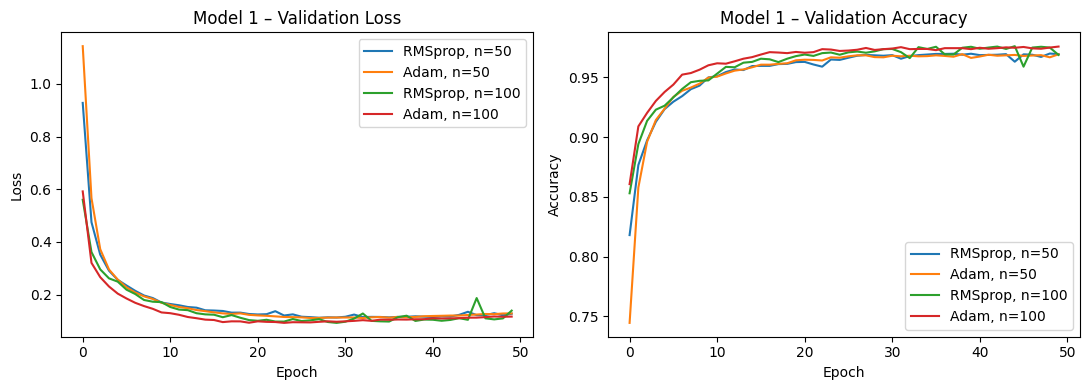

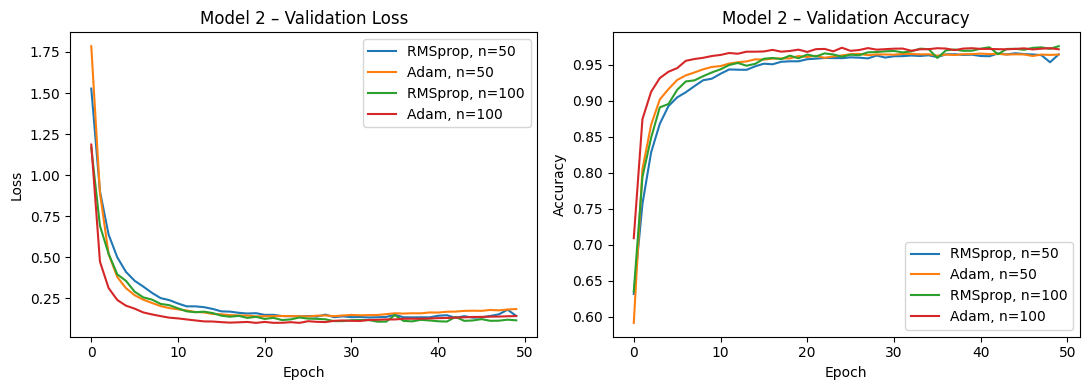

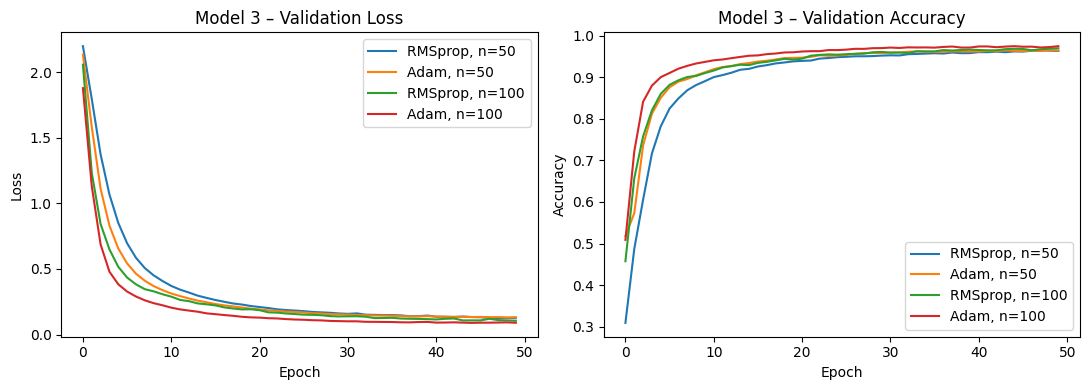

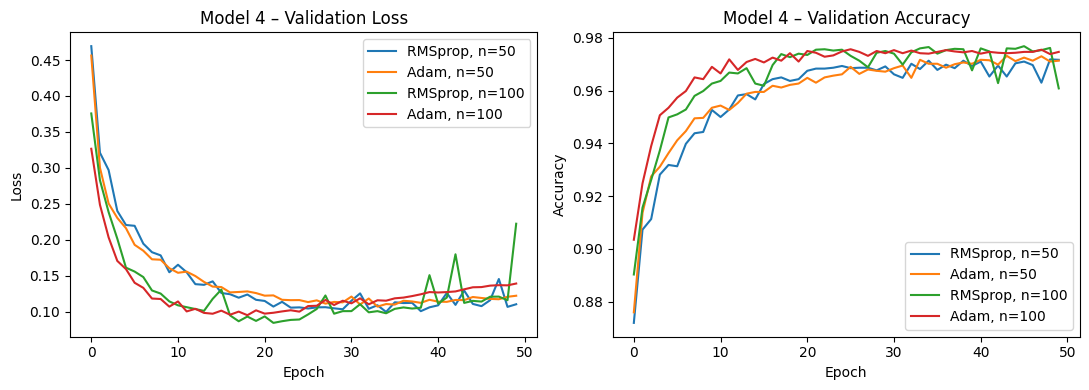

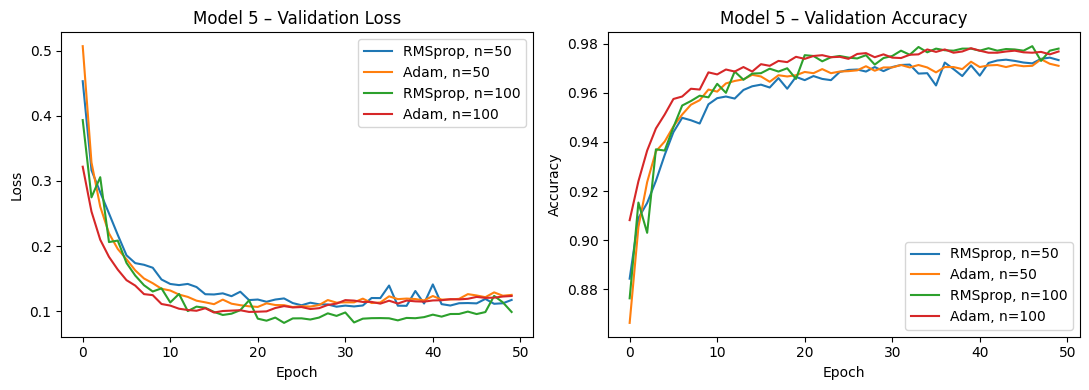

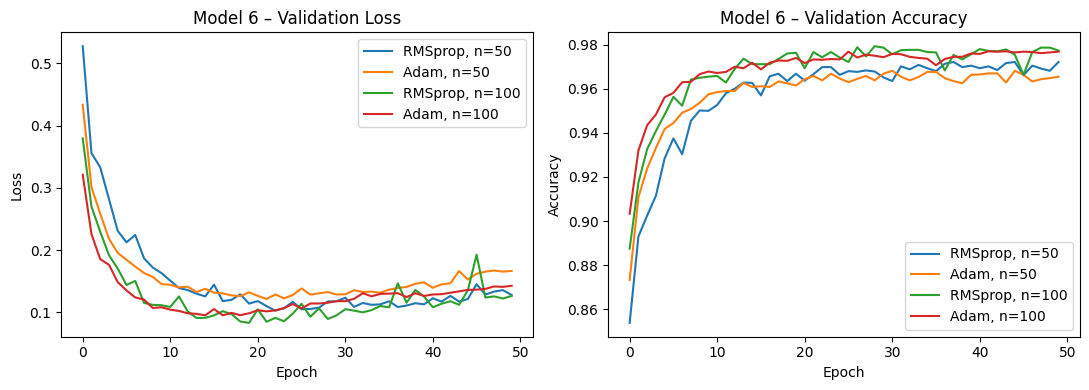

('Model 1', 50, 'RMSprop') -> Test loss=0.1212 | Test acc=0.9692
('Model 1', 50, 'Adam') -> Test loss=0.1230 | Test acc=0.9706
('Model 1', 100, 'RMSprop') -> Test loss=0.1223 | Test acc=0.9720
('Model 1', 100, 'Adam') -> Test loss=0.1123 | Test acc=0.9768
('Model 2', 50, 'RMSprop') -> Test loss=0.1343 | Test acc=0.9652
('Model 2', 50, 'Adam') -> Test loss=0.1897 | Test acc=0.9650
('Model 2', 100, 'RMSprop') -> Test loss=0.1007 | Test acc=0.9759
('Model 2', 100, 'Adam') -> Test loss=0.1502 | Test acc=0.9720
('Model 3', 50, 'RMSprop') -> Test loss=0.1129 | Test acc=0.9668
('Model 3', 50, 'Adam') -> Test loss=0.1144 | Test acc=0.9678
('Model 3', 100, 'RMSprop') -> Test loss=0.0953 | Test acc=0.9716
('Model 3', 100, 'Adam') -> Test loss=0.0887 | Test acc=0.9747
('Model 4', 50, 'RMSprop') -> Test loss=0.1090 | Test acc=0.9731
('Model 4', 50, 'Adam') -> Test loss=0.1125 | Test acc=0.9719
('Model 4', 100, 'RMSprop') -> Test loss=0.1901 | Test acc=0.9646
('Model 4', 100, 'Adam') -> Test loss=0

In [ ]:
def plot_model_curves(model_name):
    plt.figure(figsize=(11,4))
    # -- Loss (val) : 4 courbes --i
    plt.subplot(1,2,1)
    for n in nb_neurons:
        for opti_name in optimizers.keys():
            h = histories[(model_name, n, opti_name)]
            plt.plot(h.history["val_loss"], label=f"{opti_name}, n={n}")
    plt.title(f"{model_name} – Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    # -- Accuracy (val) : 4 courbes --
    plt.subplot(1,2,2)
    for n in nb_neurons:
        for opti_name in optimizers.keys():
            h = histories[(model_name, n, opti_name)]
            # (si tu es en Sparse, la clé est 'val_sparse_categorical_accuracy')
            key_acc = "val_accuracy" if "val_accuracy" in h.history else "val_sparse_categorical_accuracy"
            plt.plot(h.history[key_acc], label=f"{opti_name}, n={n}")
    plt.title(f"{model_name} – Validation Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()

for model_name in models.keys():
    plot_model_curves(model_name)
    
# ------------ (option) PERF TEST FINALE ------------
for key, mdl in trained_models.items():
    test_loss, test_acc = mdl.evaluate(x_test, y_test, verbose=0)
    print(f"{key} -> Test loss={test_loss:.4f} | Test acc={test_acc:.4f}")


I obersve that all these models have approximately the same performance. The two optimizers work well but RMSProp produces the best performances with 100 neurons. The best model is model 6 with 100 neurons and RMSProp as optimizer. 

### Loss surface observation

In this part, I plot an interpolation between the optimal solution found and three different initial points. It enables me to observe the curvature of the loss function.

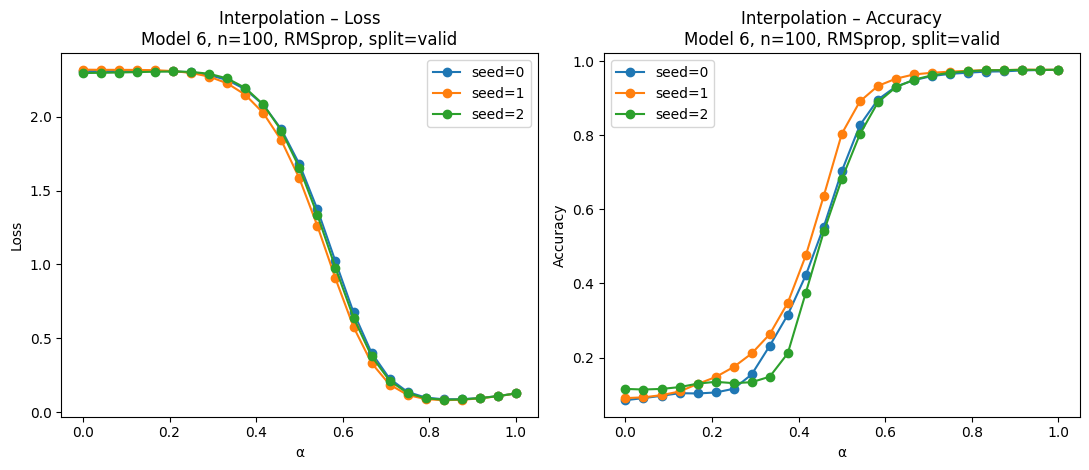

,best_acc,min_loss
seed,,
1,0.977667,0.080466
0,0.977333,0.086613
2,0.977333,0.083407


In [58]:
BEST_MODEL_NAME = "Model 6"     
NB_NEURONS      = 100
OPTI_PICK       = "RMSprop"    
EVAL_ON         = "valid"       # "valid" or "test"
NUM_POINTS      = 25            #number of interpolation points
SEEDS_STARTS    = [0, 1, 2]     # seeds for each initialization point

def match_key(k):
    if isinstance(k, tuple) and len(k) >= 3:
        m, n, opti = k[0], k[1], k[2]
        return (m == BEST_MODEL_NAME) and (n == NB_NEURONS) and (str(opti).lower() == OPTI_PICK.lower())
    return False

candidate_keys = [k for k in trained_models.keys() if match_key(k)]
target_key = candidate_keys[0]
target_model = trained_models[target_key]

# Evaluation dataset
X_eval, Y_eval = (x_valid, y_valid) if EVAL_ON == "valid" else (x_test, y_test)

# Final weights
theta_final_target = [np.array(w, copy=True) for w in target_model.get_weights()]

# Helper
def build_cold_start(seed):
    tf.keras.utils.set_random_seed(seed)
    m0 = models[BEST_MODEL_NAME](NB_NEURONS)
    m0.compile(optimizer=optimizers[OPTI_PICK](), loss=loss, metrics=["accuracy"])
    # IMPORTANT: build via  a forward pass
    _ = m0(X_eval[:1])
    w0 = [np.array(w, copy=True) for w in m0.get_weights()]
    return m0, w0

def assert_same_structure(wA, wB):
    assert len(wA) == len(wB), f"Len mismatch: {len(wA)} vs {len(wB)}"
    for i, (a, b) in enumerate(zip(wA, wB)):
        if a.shape != b.shape:
            raise AssertionError(f"Shape mismatch at idx {i}: {a.shape} vs {b.shape}")

def interpolate(theta_a, theta_b, alpha):
    out = []
    for wa, wb in zip(theta_a, theta_b):
        w = (1.0 - alpha) * wa + alpha * wb
        out.append(np.asarray(w, dtype=wa.dtype))
    return out

# Create three starting points
cold_runs = []
for s in SEEDS_STARTS:
    m0, w0 = build_cold_start(s)
    assert_same_structure(w0, theta_final_target)
    cold_runs.append({"seed": s, "model": m0, "w0": w0})

alphas = np.linspace(0.0, 1.0, NUM_POINTS)
rows = []

for run in cold_runs:
    m0 = run["model"]
    w0 = run["w0"]
    w_save = [np.array(w, copy=True) for w in m0.get_weights()]

    for a in alphas:
        w_alpha = interpolate(w0, theta_final_target, a)
        m0.set_weights(w_alpha)
        loss_a, acc_a = m0.evaluate(X_eval, Y_eval, verbose=0)
        rows.append({"seed": run["seed"], "alpha": float(a), "loss": float(loss_a), "acc": float(acc_a)})

    m0.set_weights(w_save)

df_interp = pd.DataFrame(rows)

# Now, I can plot
plt.figure(figsize=(11, 4.8))

plt.subplot(1,2,1)
for s in SEEDS_STARTS:
    sub = df_interp[df_interp["seed"] == s]
    plt.plot(sub["alpha"], sub["loss"], marker='o', label=f"seed={s}")
plt.title(f'Interpolation – Loss\n{BEST_MODEL_NAME}, n={NB_NEURONS}, {OPTI_PICK}, split={EVAL_ON}')
plt.xlabel('α'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
for s in SEEDS_STARTS:
    sub = df_interp[df_interp["seed"] == s]
    plt.plot(sub["alpha"], sub["acc"], marker='o', label=f"seed={s}")
plt.title(f'Interpolation – Accuracy\n{BEST_MODEL_NAME}, n={NB_NEURONS}, {OPTI_PICK}, split={EVAL_ON}')
plt.xlabel('α'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

#Quick summary
display(df_interp.groupby("seed").agg(best_acc=("acc","max"), min_loss=("loss","min")).sort_values("best_acc", ascending=False))


,top1,top2,count
40,4,9,502
15,1,7,417
54,6,5,360
79,9,4,324
69,8,3,265
60,7,3,251
5,0,6,247
65,7,9,231
49,5,9,207
1,0,2,201


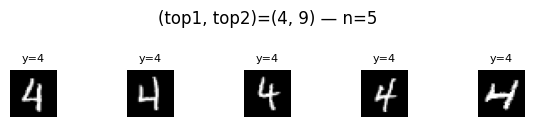

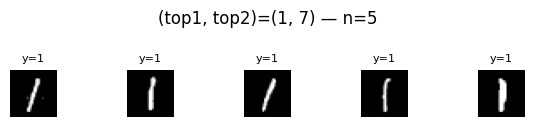

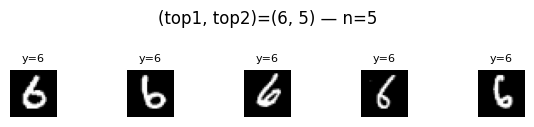

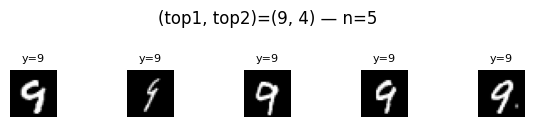

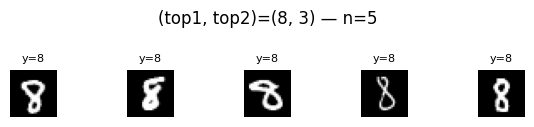

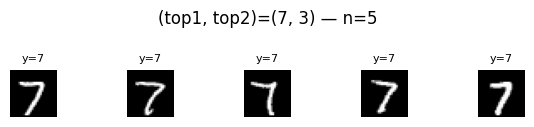

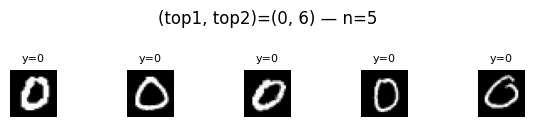

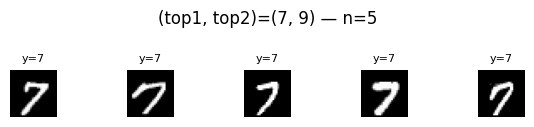

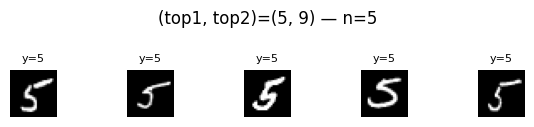

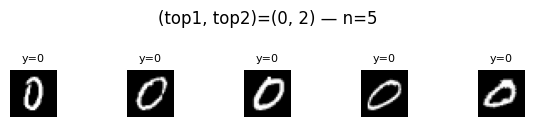

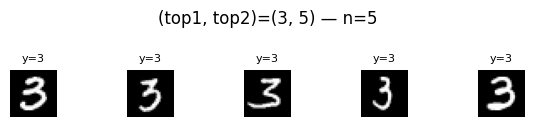

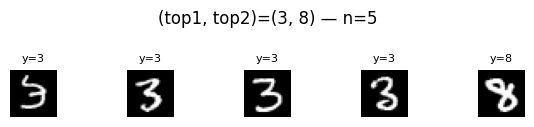

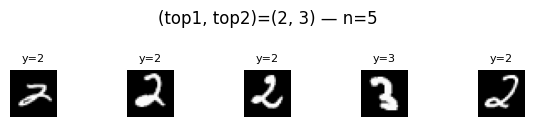

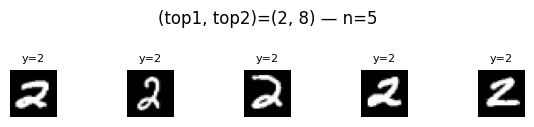

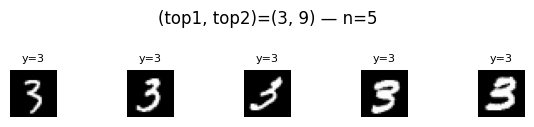

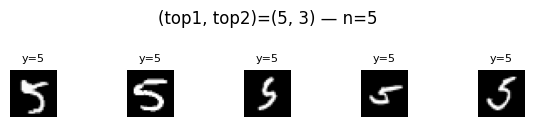

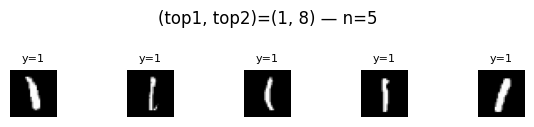

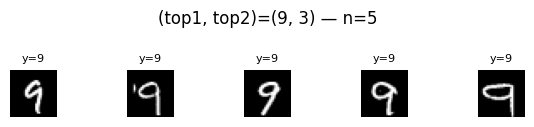

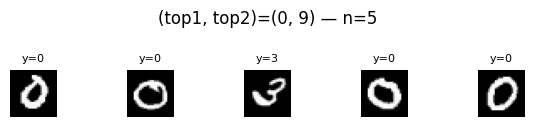

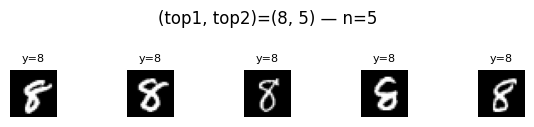

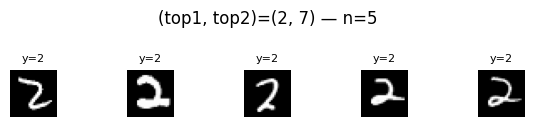

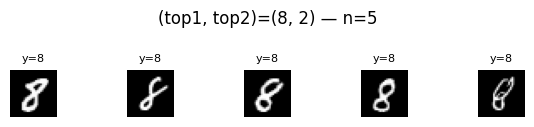

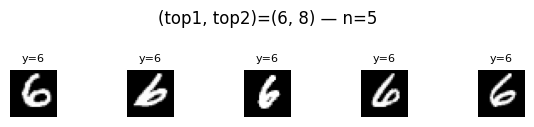

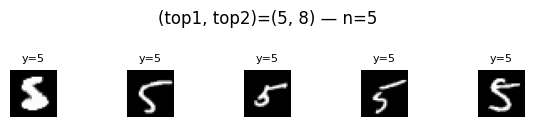

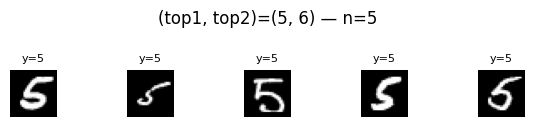

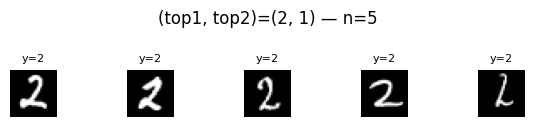

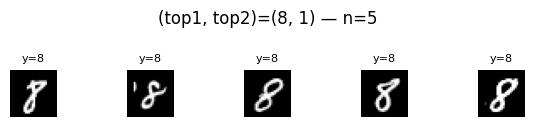

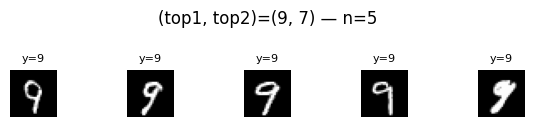

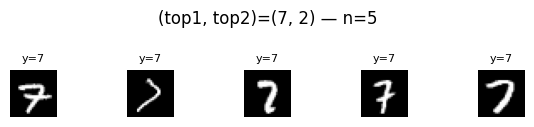

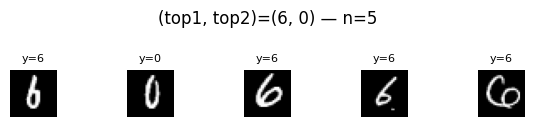

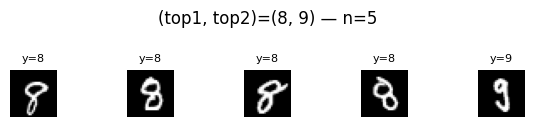

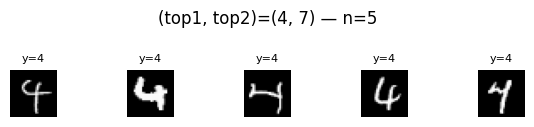

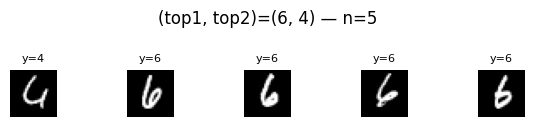

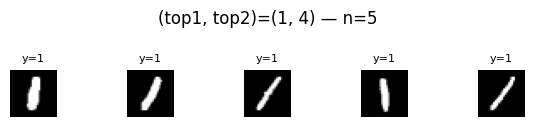

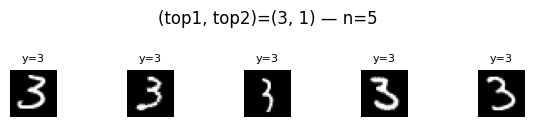

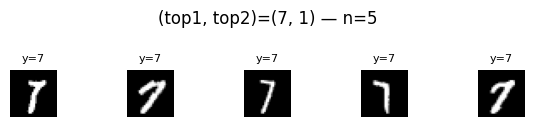

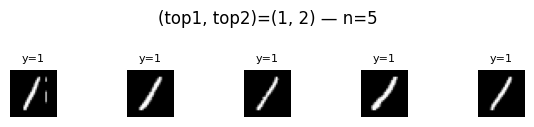

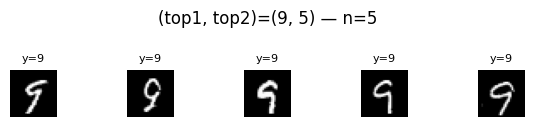

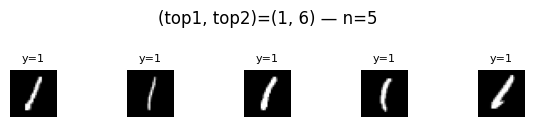

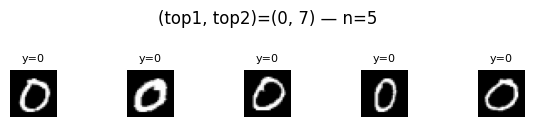

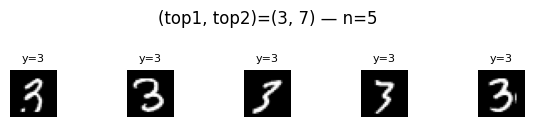

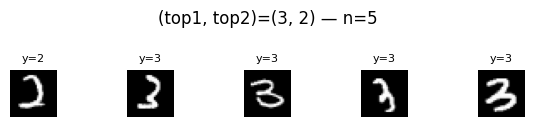

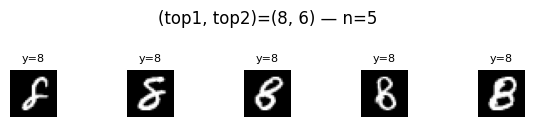

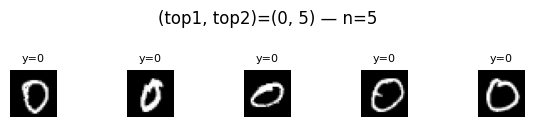

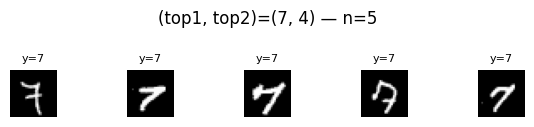

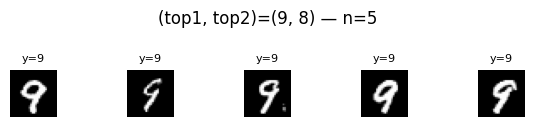

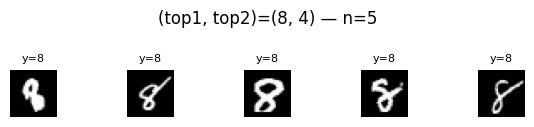

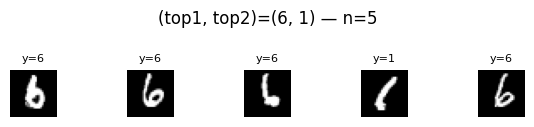

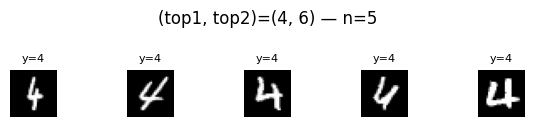

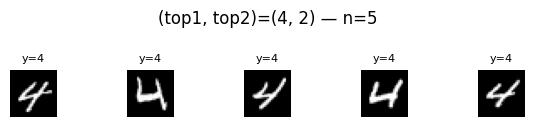

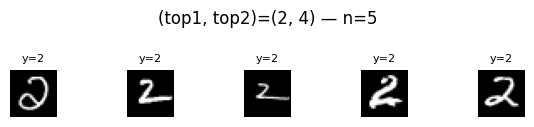

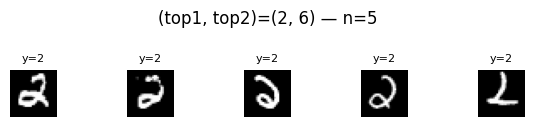

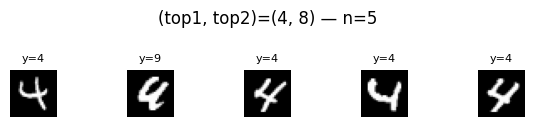

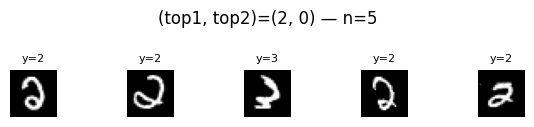

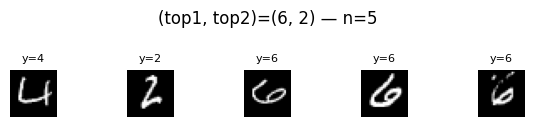

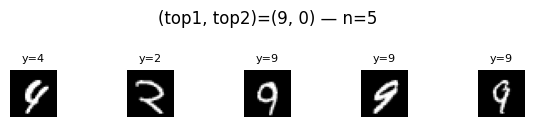

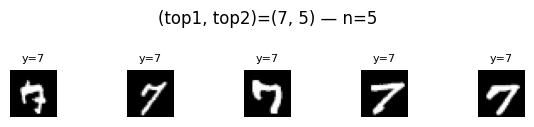

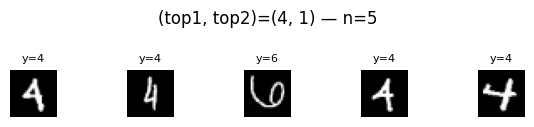

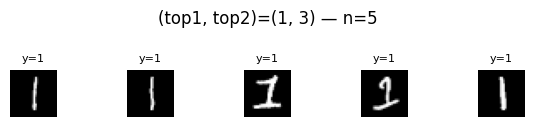

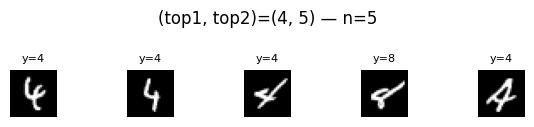

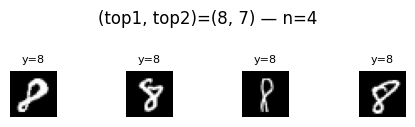

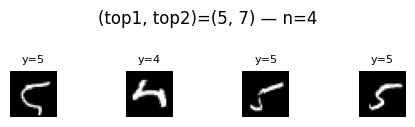

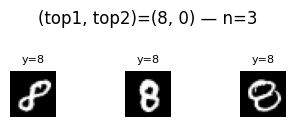

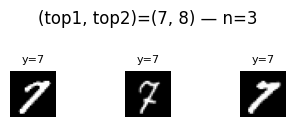

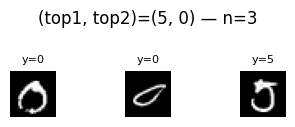

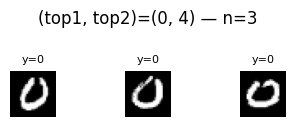

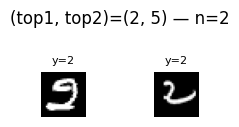

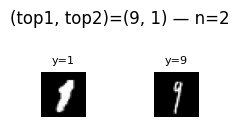

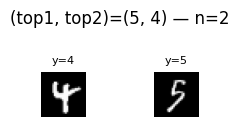

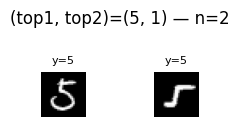

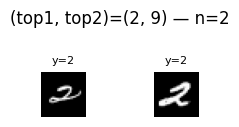

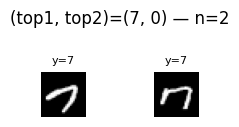

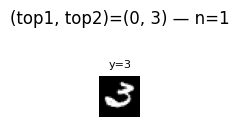

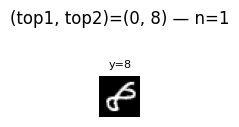

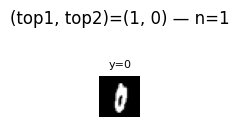

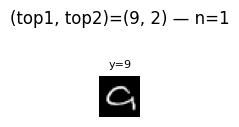

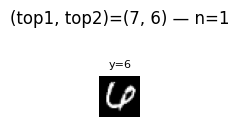

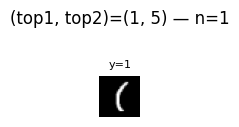

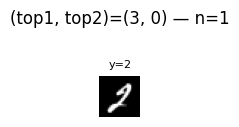

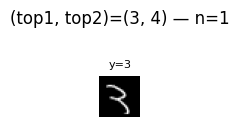

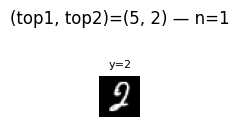

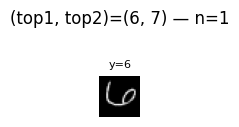

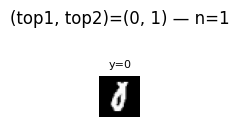

In [ ]:
# Most frequent pairs
pairs = (df_top2.groupby(["top1","top2"])
         .size().reset_index(name="count")
         .sort_values("count", ascending=False))
display(pairs.head(15))

def show_pair_samples(pair=(5,3), k=5, seed=42):
    idx = df_top2[(df_top2.top1==pair[0]) & (df_top2.top2==pair[1])].index
    if len(idx)==0:
        print(f"Aucune image pour la paire {pair}")
        return
    rng = np.random.default_rng(seed)
    take = min(k, len(idx))
    chosen = rng.choice(idx, size=take, replace=False)
    cols = min(10, take); rows = int(np.ceil(take/cols))
    plt.figure(figsize=(1.2*cols, 1.2*rows))
    for i,j in enumerate(chosen):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X_eval[j].reshape(28,28), cmap="gray")
        plt.title(f"y={df_top2.y_true[j]}", fontsize=8)
        plt.axis("off")
    plt.suptitle(f"(top1, top2)={pair} — n={take}", y=1.02)
    plt.tight_layout(); plt.show()

for r in pairs.itertuples(index=False):
    show_pair_samples((int(r.top1), int(r.top2)), k=5, seed=1)



,top1,top2,count,plausible01,reason
1,1,7,417,1,A 7 without a bar can seem like a 1
3,9,4,324,1,loop not properly closed
6,0,6,247,1,Unperfect loop
7,7,9,231,1,Too curved 7
10,3,5,195,1,Unperfect top
11,3,8,182,1,"Too curved 3, producing closed loops"
12,2,3,171,1,Stroke too thick
14,3,9,158,1,"Too curved 3, closing the top loop"
15,5,3,146,1,Unprecise top
19,8,5,95,1,Opened top loop


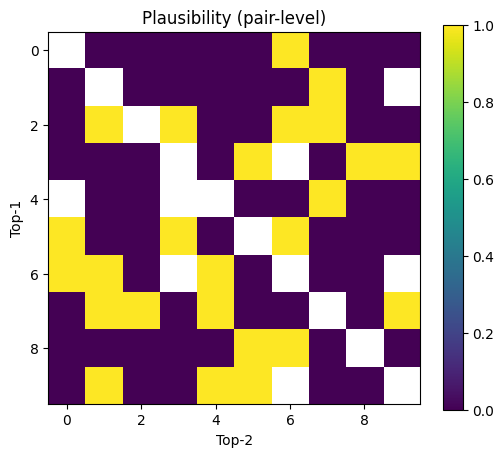

In [ ]:
#charge annotations
ann = pd.read_csv("top2_pairs_annotation_filled.csv")

#normalize the annotation in 0/1
def _to01(x):
    s = str(x).strip().lower()
    return 1 if s in ["1","yes","true"] else 0
ann["plausible01"] = ann["plausible"].apply(_to01)

ranked = (pairs.merge(ann[["top1","top2","plausible01","reason"]], on=["top1","top2"], how="left")
               .sort_values(["plausible01","count"], ascending=[False, False]))
display(ranked.head(15))

# heatmap 10x10 of couples
heat = np.full((10,10), np.nan)
for _, r in ann.iterrows():
    heat[int(r.top1), int(r.top2)] = float(r.plausible01)

plt.figure(figsize=(6,5))
im = plt.imshow(heat, vmin=0, vmax=1)
plt.title("Plausibility (pair-level)")
plt.xlabel("Top-2"); plt.ylabel("Top-1"); plt.colorbar(im); plt.show()


The mot plausible couples:


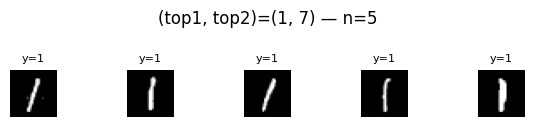

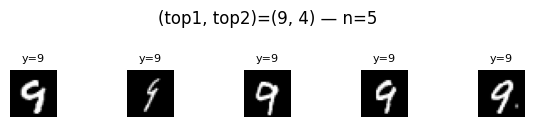

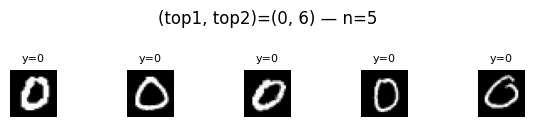

The less plausible couples:


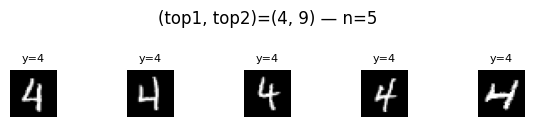

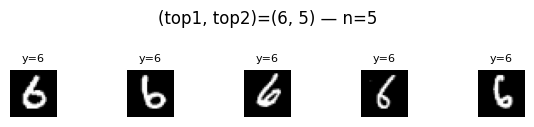

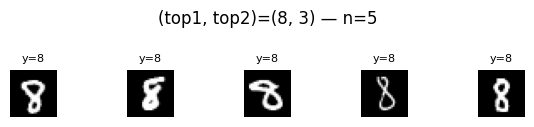

In [59]:
#top 3 most plausibles and top3 less plausible
most = ann[ann.plausible01==1].head(3)
least = ann[ann.plausible01==0].head(3)

print("The mot plausible couples:")
for _, r in most.iterrows():
    show_pair_samples((int(r.top1), int(r.top2)), k=5, seed=1)

print("The less plausible couples:")
for _, r in least.iterrows():
    show_pair_samples((int(r.top1), int(r.top2)), k=5, seed=1)


## Conclusion

To conclude, I observe that the failure mode of the MNIST database is very often due to poorly drawn loops: sometimes too big, too small, not closed...

A model working on more local patterns could be a good way to answer to this challenge.